In [111]:
import galsim
import batsim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [25]:
class FlexionTransform(object):
    """
    Feel Free to merge this method with the next one. I wanted
    to be a little more careful because I don't know how to manuever
    with centers.
    """

    def __init__(self, gamma1, gamma2, kappa, F1=0, F2=0, G1=0, G2=0, center=None):
        """Initialize the transform object of 2D grids.

        Args:
        gamma1 (float):     the first component of lensing shear field
        gamma2 (float):     the second component of lensing shear field
        kappa (float):      the lensing convergence field
        F1,F2,G1,G2 (float):  Flexion components
        """
        self.s2l_mat = np.array(
            [[1 - kappa - gamma1, -gamma2], [-gamma2, 1 - kappa + gamma1]]
        )
        self.s2l_mat_inv = np.linalg.inv(self.s2l_mat)
        D1 = -1 / 2 * np.array([[3 * F1 + G1, F2 + G2], [F2 + G2, F1 - G1]])
        D2 = -1 / 2 * np.array([[F2 + G2, F1 - G1], [F1 - G1, 3 * F2 - G2]])
        self.D = np.stack([D1, D2], axis=2)

        if center == None:
            center = [0, 0]

        self.ref_vec = np.array([[center[0]], [center[1]]])

        return

    def transform(self, coords):
        """
        Transform the center of pixels from lensed plane to
        pre-lensed plane.

        Args:
        coords: coordinates (x, y) of the pixel centers [arcsec]
        """

        coords_relative = coords - self.ref_vec
        return self.s2l_mat @ coords + np.einsum(
            "ijk,jl,kl->il", self.D, coords_relative, coords_relative
        ) + self.ref_vec

    def inverse_transform(self, coords):
        """
        Details about this inverse transformation can be found
        here:
        https://github.com/garyang3/Notes/blob/main/Flexion_inverse_transform.pdf
        """
        theta_0 = np.einsum("ij,jk", self.s2l_mat_inv, coords)
        theta_1 = (
            -1
            / 2
            * np.einsum(
                "in,ijk,jl,lo,km,mo->no",
                self.s2l_mat_inv,
                self.D,
                self.s2l_mat_inv,
                coords,
                self.s2l_mat_inv,
                coords,
            )
        )
        return theta_0 + theta_1

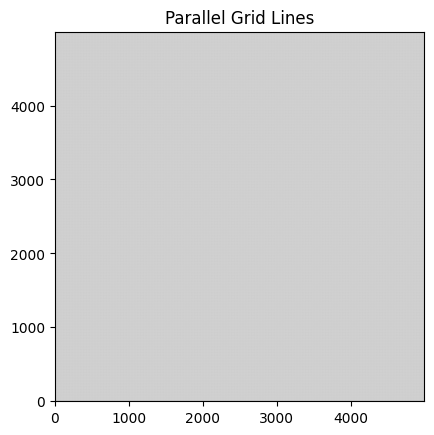

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the grid size
nn_large = 5000

# Step 2: Create the 2D array with parallel lines
# You can create vertical or horizontal lines by modifying this
grid = np.ones((nn_large, nn_large))

# Define the spacing and width of the grid lines
line_spacing = 10
line_width = 1

for i in range(0, nn_large, line_spacing):
    grid[:, i:i+line_width] = 0  # Vertical lines
    grid[i:i+line_width, :] = 0  # Horizontal lines

# Step 3: Plot using imshow
plt.imshow(grid, cmap='gray', origin='lower')
plt.title("Parallel Grid Lines")
plt.show()

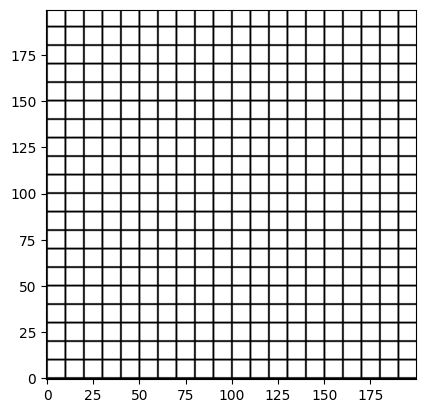

In [27]:
nn = 200

indx = np.arange(-int(nn / 2), int((nn + 1) / 2), 1)
indy = np.arange(-int(nn / 2), int((nn + 1) / 2), 1)
inds = np.meshgrid(indy, indx, indexing="ij")
# coords in shape of (2, npoints), in order of [x, y]
coords = np.vstack([np.ravel(_) for _ in inds[::-1]])

# Null transform to test it works
flexion_transform = FlexionTransform(
    gamma1=0.,
    gamma2=0.,
    kappa=0.,
    F1=0.,
    F2=0.,
    G1=0.,
    G2=0.,
)

transformed_coords = flexion_transform.transform(coords)

transform_grid = np.array([grid[int(cc[0]), int(cc[1])] for cc in transformed_coords.T])

plt.imshow(transform_grid.reshape(nn, nn), cmap='gray', origin='lower')

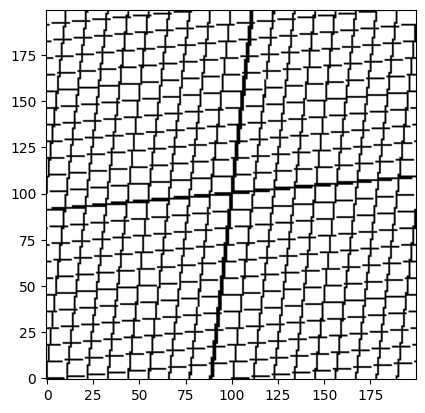

In [28]:
# Now lets put some affine shear values
flexion_transform = FlexionTransform(
    gamma1=0.1,
    gamma2=0.1,
    kappa=0.0,
    F1=0.0,
    F2=0.0,
    G1=0.0,
    G2=0.0,
)

transformed_coords = flexion_transform.transform(coords)

transform_grid = np.array([grid[int(cc[0]), int(cc[1])] for cc in transformed_coords.T])

plt.imshow(transform_grid.reshape(nn, nn), cmap='gray', origin='lower')


### Missing some values due to rouding but this isn't a problem with actual galsim objects as
# flux can be calculate at any image coordinate

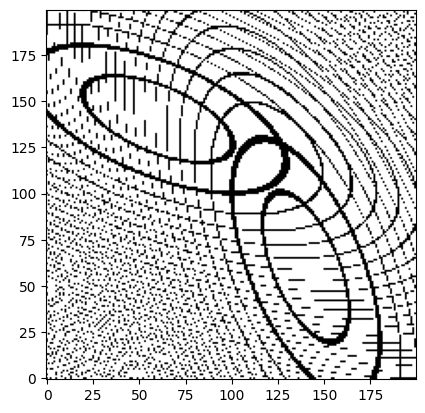

In [163]:
# Moving onto non affine...
flexion_transform = FlexionTransform(
    gamma1=0.0,
    gamma2=0.0,
    kappa=0.2,
    F1=0.01,
    F2=0.01,
    G1=0.0,
    G2=0.0,
)

transformed_coords = flexion_transform.transform(coords)

transform_grid = np.array([grid[int(cc[0]), int(cc[1])] for cc in transformed_coords.T])

plt.imshow(transform_grid.reshape(nn, nn), cmap='gray', origin='lower')


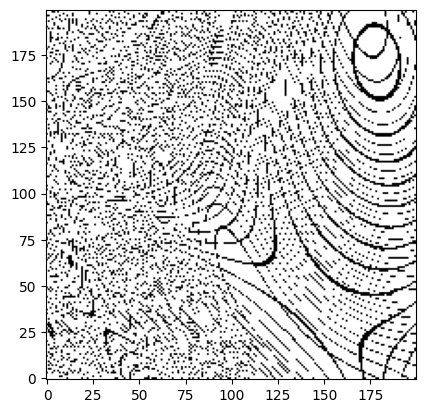

In [30]:
# Multiple non affine shears with different centers
flexion_transform1 = FlexionTransform(
    gamma1=0.1,
    gamma2=0.0,
    kappa=0.0,
    F1=0.01,
    F2=0.0,
    G1=0.0,
    G2=0.0,
    center=[50,50]
)

flexion_transform2 = FlexionTransform(
    gamma1=0.1,
    gamma2=0.0,
    kappa=0.0,
    F1=0.01,
    F2=0.0,
    G1=0.0,
    G2=0.0,
    center=[-50,-50]
)

transformed_coords = flexion_transform1.transform(coords)
transformed_coords = flexion_transform2.transform(transformed_coords)

transform_grid = np.array([grid[int(cc[0]), int(cc[1])] for cc in transformed_coords.T])

plt.imshow(transform_grid.reshape(nn, nn), cmap='gray', origin='lower')

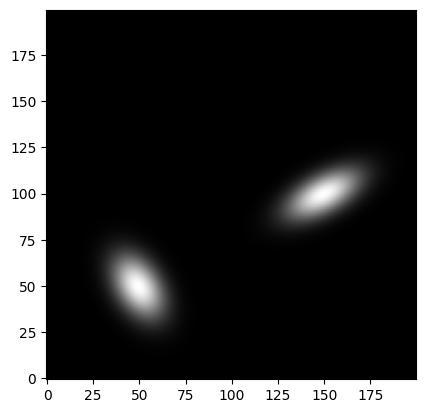

In [31]:
gal1 = galsim.Gaussian(sigma=1.0, flux=1.0).shear(g1=0.2, g2=0.3).shift(50*0.1,0)
gal2 = galsim.Gaussian(sigma=1.0, flux=1.0).shear(g1=-0.1, g2=-0.2).shift(-5,-5)
im1 = gal1.drawImage(nx=200, ny=200, scale=0.1)
im2 = gal2.drawImage(nx=200, ny=200, scale=0.1)

image = im1 + im2
plt.imshow(image.array, cmap='gray', origin='lower')

[0 1]


[58067 34086 60620 32399 55985 41239  9449 23706  8222 33950]


10it [00:06,  1.50it/s]


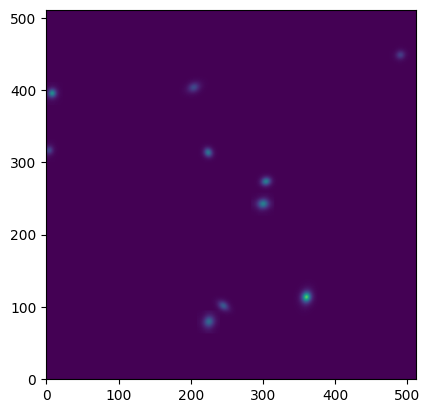

In [125]:
# Function to shift the image and fill the edges with zeros
def shift_image(image, shift_x, shift_y):
    shifted_image = np.roll(image, shift=(int(shift_y), int(shift_x)), axis=(0, 1))

    if shift_x > 0:
        shifted_image[:, :int(shift_x)] = 0
    elif shift_x < 0:
        shifted_image[:, int(shift_x):] = 0

    if shift_y > 0:
        shifted_image[:int(shift_y), :] = 0
    elif shift_y < 0:
        shifted_image[int(shift_y):, :] = 0

    return shifted_image

# Create PSF and galaxy objects
psf_obj = galsim.Moffat(beta=3.5, fwhm=0.8, trunc=4*0.8)

#np.random.seed
rng = np.random.RandomState(1234)
cosmos = galsim.COSMOSCatalog()
inds = rng.choice(len(cosmos), 10)
print(inds)
gals = cosmos.makeGalaxy(index=inds, gal_type='parametric')

# large exposure
npix = 512
pixel_scale = 0.1
im_list = []
for i, gal in tqdm(enumerate(gals)):
    # ensure galaxy doesn't leave image
    shift_x = rng.uniform(-npix*0.5, npix*0.5)
    shift_y = rng.uniform(-npix*0.5, npix*0.5)

    gamma1 = rng.uniform(-0.01, 0.01)
    gamma2 = rng.uniform(-0.01, 0.01)
    kappa = rng.uniform(-0.01, 0.01)
    F1 = rng.uniform(-0.01, 0.01)
    F2 = rng.uniform(-0.01, 0.01)
    G1 = rng.uniform(-0.01, 0.01)
    G2 = rng.uniform(-0.01, 0.01)
    
    flexion_transform = FlexionTransform(
        gamma1=gamma1,
        gamma2=gamma2,
        kappa=kappa,
        F1=F1,
        F2=F2,
        G1=G1,
        G2=G2,
    )

    img = batsim.simulate_galaxy(
        ngrid=npix, # number of pixels in each dimension
        pix_scale=pixel_scale, # arcsec/pixel
        gal_obj=gal, # galsim galaxy object
        transform_obj=flexion_transform, # transform class telling BATSim what coordinate to request flux at
        psf_obj=psf_obj, # PSF to convolve with image after shearing
        draw_method="auto", # Include pixel response
        force_ngrid=False, # Force the number of pixels in each dimension for simulation if calculate size is smaller
    )

    # shift the image to recenter the galaxy in the image
    img = shift_image(img, shift_x, shift_y)

    im_list.append(img)

img = np.sum(im_list, axis=0)

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.1)
plt.imshow(img, origin='lower', norm=norm)

DONE: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


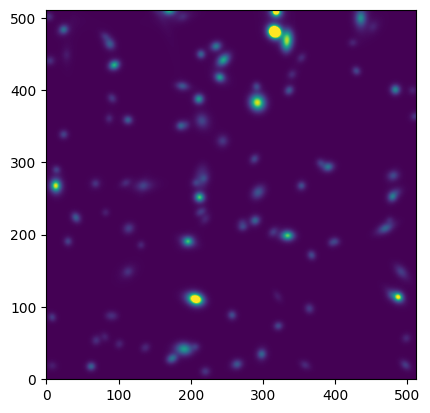

In [171]:
import galsim
import batsim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from parallelbar import progress_starmap

# Function to shift the image and fill the edges with zeros
def shift_image(image, shift_x, shift_y):
    shifted_image = np.roll(image, shift=(int(shift_y), int(shift_x)), axis=(0, 1))

    if shift_x > 0:
        shifted_image[:, :int(shift_x)] = 0
    elif shift_x < 0:
        shifted_image[:, int(shift_x):] = 0

    if shift_y > 0:
        shifted_image[:int(shift_y), :] = 0
    elif shift_y < 0:
        shifted_image[int(shift_y):, :] = 0

    return shifted_image

# define function to be parallelized
def shear_and_shift(n_pix, pixel_scale, gal, psf_obj, shift_x, shift_y, gamma1, gamma2, kappa, F1, F2, G1, G2):

    # Flexion transform object to be passed to BATSim
    flexion_transform = FlexionTransform(
        gamma1=gamma1,
        gamma2=gamma2,
        kappa=kappa,
        F1=F1,
        F2=F2,
        G1=G1,
        G2=G2,
    )

    # simulate galaxy and get image with galaxy centered
    img = batsim.simulate_galaxy(
        ngrid=n_pix, # number of pixels in each dimension
        pix_scale=pixel_scale, # arcsec/pixel
        gal_obj=gal, # galsim galaxy object
        transform_obj=flexion_transform, # transform class telling BATSim what coordinate to request flux at
        psf_obj=psf_obj, # PSF to convolve with image after shearing
        draw_method="auto", # Include pixel response
        force_ngrid=False, # Force the number of pixels in each dimension for simulation if calculated size is smaller
        maximum_num_grids=10000 # Controls maximum possible sim size, 
                                # may lead to clipping of flux at edges of light profile for large galaxies if set too low 
    )
    
    # shift the image so the galaxy is not at the center
    img = shift_image(img, shift_x, shift_y)

    return img

# define parameters to be passed to function
n_pix = 512
pixel_scale = 0.1
psf_obj = galsim.Moffat(beta=3.5, fwhm=0.8, trunc=4*0.8)

# for an example we just randomise everything
rng = np.random.RandomState(1234)
inds = rng.choice(len(cosmos), 100)
gal_list = cosmos.makeGalaxy(index=inds, gal_type='parametric')

# position of galaxies
shift_x = rng.uniform(-n_pix*0.5, n_pix*0.5, len(gal_list))
shift_y = rng.uniform(-n_pix*0.5, n_pix*0.5, len(gal_list))

# shear parameters
gamma1 = rng.uniform(-0.1, 0.1, len(gal_list))
gamma2 = rng.uniform(-0.1, 0.1, len(gal_list))
kappa = rng.uniform(-0.1, 0.1, len(gal_list))
F1 = rng.uniform(-0.05, 0.05, len(gal_list))
F2 = rng.uniform(-0.01, 0.01, len(gal_list))
G1 = rng.uniform(-0.01, 0.01, len(gal_list))
G2 = rng.uniform(-0.01, 0.01, len(gal_list))

# Force galsim into single threading so we can batch process galaxies
original_omp_num_threads = os.environ.get("OMP_NUM_THREADS", None)
os.environ["OMP_NUM_THREADS"] = "1"

# construct list of arguments to be passed to paralellised function
args_list = [
    (
        n_pix, 
        pixel_scale, 
        gal, 
        psf_obj, 
        shift_x[i], 
        shift_y[i], 
        gamma1[i], 
        gamma2[i], 
        kappa[i], 
        F1[i], 
        F2[i], 
        G1[i], 
        G2[i]
        ) for i, gal in enumerate(gal_list)
]

# collect resulting images in a list
outcome = progress_starmap(shear_and_shift, args_list, n_cpu=40)

# return OMP env variable to default state
if original_omp_num_threads is None:
    del os.environ['OMP_NUM_THREADS']
else:
    os.environ['OMP_NUM_THREADS'] = original_omp_num_threads

# sum all images to get final image
img = np.sum(outcome, axis=0)

# plot the final image
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.2) # random norm values I find work well
plt.imshow(img, origin='lower', norm=norm)
plt.savefig("galaxy_scene_nonaffine.png")

In [172]:
# Now do single shear field originating at center
import galsim
import batsim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from parallelbar import progress_starmap

# define function to be parallelized
def shear_and_shift(n_pix, pixel_scale, gal, psf_obj, shift_x, shift_y, gamma1, gamma2, kappa, F1, F2, G1, G2):

    # Flexion transform object to be passed to BATSim
    flexion_transform = FlexionTransform(
        gamma1=gamma1,
        gamma2=gamma2,
        kappa=kappa,
        F1=F1,
        F2=F2,
        G1=G1,
        G2=G2,
        center=[0, 0]
    )

    gal = gal.shift(shift_x*pixel_scale, shift_y*pixel_scale)

    # simulate galaxy and get image with galaxy centered
    img = batsim.simulate_galaxy(
        ngrid=n_pix, # number of pixels in each dimension
        pix_scale=pixel_scale, # arcsec/pixel
        gal_obj=gal, # galsim galaxy object
        transform_obj=flexion_transform, # transform class telling BATSim what coordinate to request flux at
        psf_obj=psf_obj, # PSF to convolve with image after shearing
        draw_method="auto", # Include pixel response
        force_ngrid=False, # Force the number of pixels in each dimension for simulation if calculated size is smaller
        maximum_num_grids=8000 # Controls maximum possible sim size, 
                                # may lead to clipping of flux at edges of light profile for large galaxies if set too low 
    )

    return img

# define parameters to be passed to function
n_pix = 512
pixel_scale = 0.1
psf_obj = galsim.Moffat(beta=3.5, fwhm=0.8, trunc=4*0.8)

# for an example we just randomise everything
rng = np.random.RandomState(1234)
inds = rng.choice(len(cosmos), 500)
gal_list = cosmos.makeGalaxy(index=inds, gal_type='parametric')

# position of galaxies
shift_x = rng.uniform(-n_pix*0.5, n_pix*0.5, len(gal_list))
shift_y = rng.uniform(-n_pix*0.5, n_pix*0.5, len(gal_list))

# shear parameters
gamma1 = 0.1
gamma2 = 0.1
kappa = 0.2
F1 = 0.01
F2 = 0.01
G1 = 0.0
G2 = 0.0

# Force galsim into single threading so we can batch process galaxies
original_omp_num_threads = os.environ.get("OMP_NUM_THREADS", None)
os.environ["OMP_NUM_THREADS"] = "1"

# construct list of arguments to be passed to paralellised function
args_list = [
    (
        n_pix, 
        pixel_scale, 
        gal, 
        psf_obj, 
        shift_x[i], 
        shift_y[i], 
        gamma1, 
        gamma2, 
        kappa, 
        F1, 
        F2, 
        G1, 
        G2
        ) for i, gal in enumerate(gal_list)
]

# collect resulting images in a list
outcome = progress_starmap(shear_and_shift, args_list, n_cpu=40)

# return OMP env variable to default state
if original_omp_num_threads is None:
    del os.environ['OMP_NUM_THREADS']
else:
    os.environ['OMP_NUM_THREADS'] = original_omp_num_threads

# sum all images to get final image
img = np.sum(outcome, axis=0)

# plot the final image
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.2) # random norm values I find work well
# plot scene and grid lines as sub plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, origin='lower', norm=norm)


# Flexion transform object to be passed to BATSim
flexion_transform = FlexionTransform(
    gamma1=gamma1,
    gamma2=gamma2,
    kappa=kappa,
    F1=F1,
    F2=F2,
    G1=G1,
    G2=G2,
    center=[0, 0]
)
transformed_coords = flexion_transform.transform(coords)
transform_grid = np.array([grid[int(cc[0]), int(cc[1])] for cc in transformed_coords.T])

ax[1].imshow(transform_grid.reshape(nn, nn), cmap='gray', origin='lower')
plt.savefig("galaxy_scene_nonaffine_central.png")

DONE:  23%|██▎       | 114/500 [00:25<01:14,  5.20it/s]